In [70]:
#Bone Fracture Detection

In [81]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd 
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [83]:
# Define the paths to the datasets
data_dir = Path('data\\bonefracture')
train_dir = data_dir / 'train'
test_dir = data_dir /'test'
val_dir = data_dir / 'valid'

In [85]:
#3. Define Parameters This cell defines parameters such as batch size and image dimensions.

In [87]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [89]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 8863 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [90]:
class_names = train_ds.class_names
class_names

['fractured', 'not fractured']

In [93]:
class_names = train_ds.class_names

def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

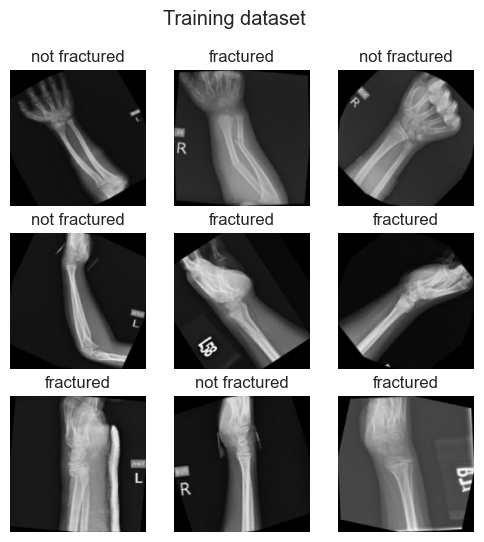

In [95]:
show_images(train_ds, 'Training dataset')

In [96]:
#Plot class distributions

In [99]:
def count_classes(dataset, class_name):
    return len(list(Path.glob(dataset, f"{class_name}/*")))

def create_class_counts_df(dataset, class_names):
    counts = {'class':[], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

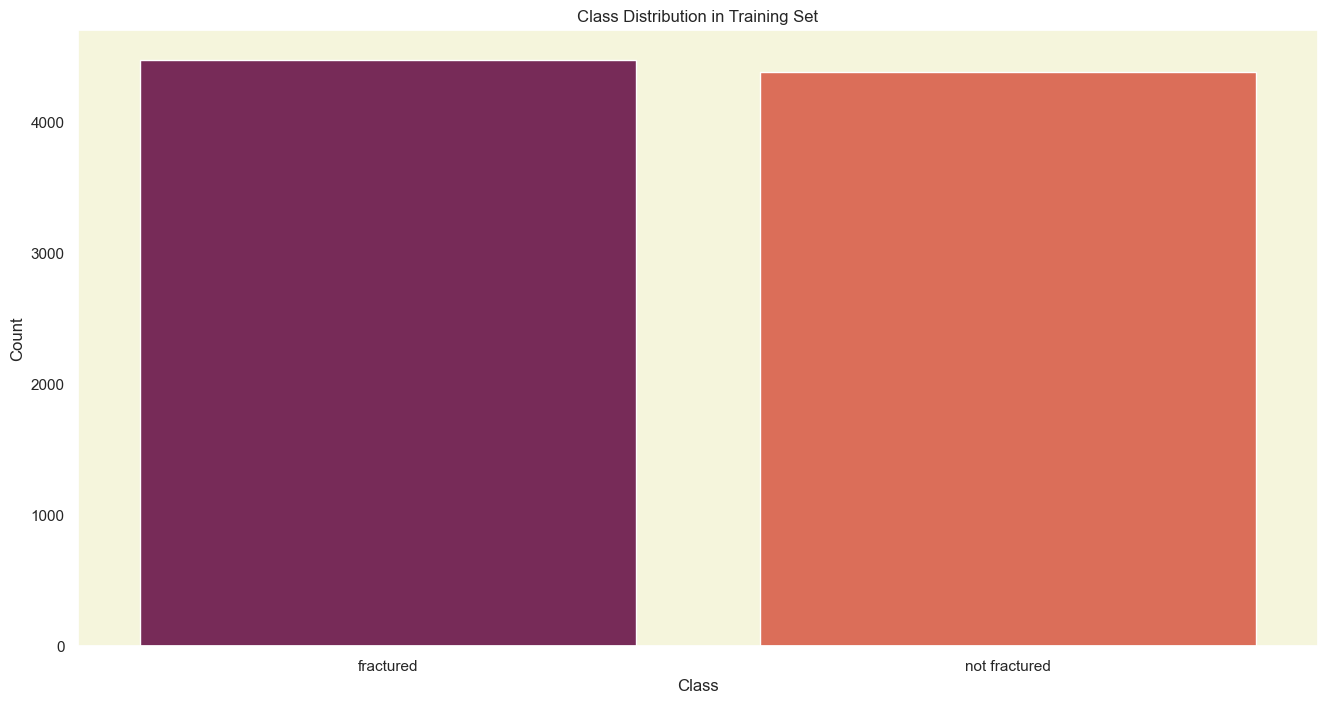

In [101]:
train_df = create_class_counts_df(train_dir, class_names)
plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')

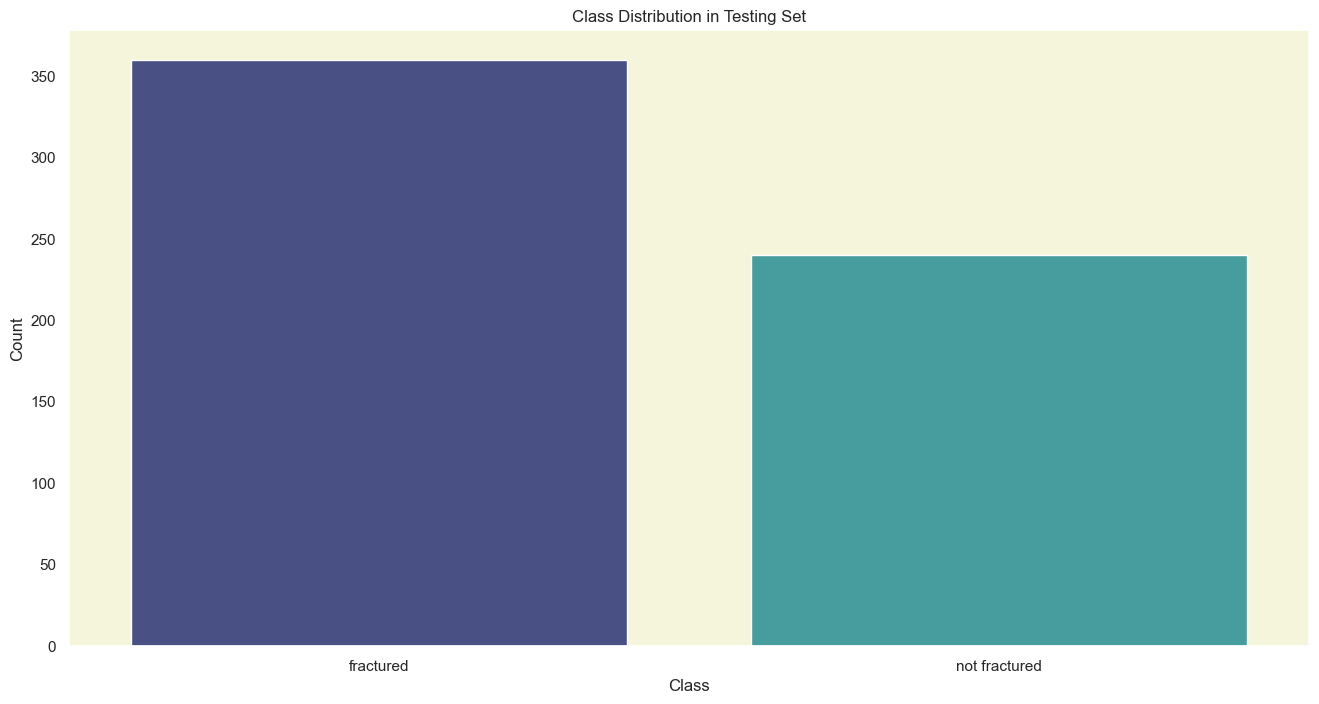

In [103]:
test_df = create_class_counts_df(test_dir, class_names)
plot_class_distribution(test_df, 'Class Distribution in Testing Set', palette='mako')

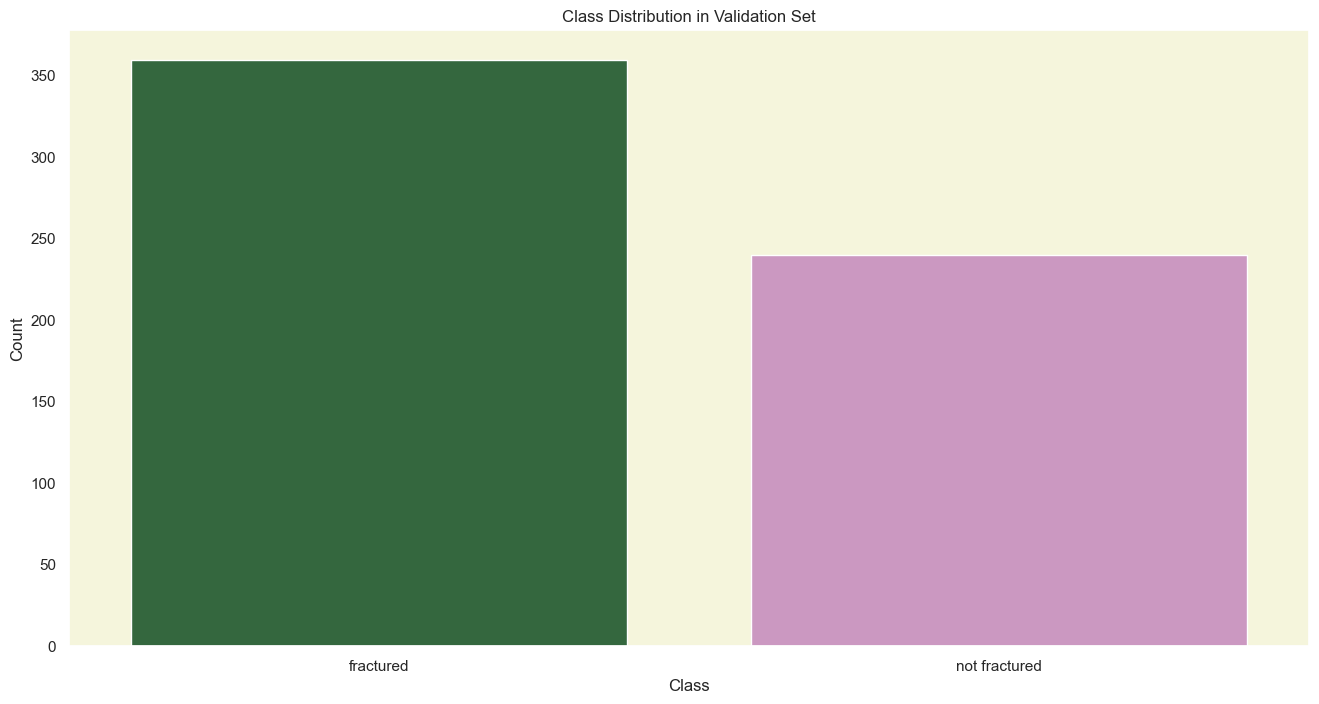

In [105]:
val_df = create_class_counts_df(val_dir, class_names)
plot_class_distribution(val_df, 'Class Distribution in Validation Set', palette='cubehelix')

In [107]:
#This cell use ImageDataGenerator for loading and augmenting the training, validation, and test datasets.

In [109]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [111]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 8863 images belonging to 2 classes.


In [113]:
test_set = train_datagen.flow_from_directory(test_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 600 images belonging to 2 classes.


In [115]:
val_set = train_datagen.flow_from_directory(val_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 600 images belonging to 2 classes.


In [117]:
#This cell defines the Convolutional Neural Network (CNN) model architecture

In [119]:
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
#This cell compiles the model, specifying the optimizer, loss function, and metrics.

In [123]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [125]:
#This cell trains the model using the training dataset and validates it using the validation dataset, saving the training history.

In [127]:
history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=10
                   )

Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 133s 470ms/step - accuracy: 0.5755 - loss: 0.7064 - val_accuracy: 0.5767 - val_loss: 0.6459
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 134s 478ms/step - accuracy: 0.6983 - loss: 0.5629 - val_accuracy: 0.7000 - val_loss: 0.5229
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 136s 484ms/step - accuracy: 0.8167 - loss: 0.3925 - val_accuracy: 0.6817 - val_loss: 0.6506
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 139s 495ms/step - accuracy: 0.8878 - loss: 0.2557 - val_accuracy: 0.6950 - val_loss: 0.5748
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 132s 469ms/step - accuracy: 0.9274 - loss: 0.1791 - val_accuracy: 0.7483 - val_loss: 0.5735
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 130s 464ms/step - accuracy: 0.9487 - loss: 0.1269 - val_accuracy: 0.6733 - val_loss: 0.8117
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 124s 442ms/step - accuracy: 0.9629 - loss: 0.1050 - val_accuracy: 0.6450 - val_loss: 1.1069
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 133s 473ms/step - accuracy: 0.9685 -

In [128]:
#This cell evaluates the trained model on the test dataset and prints the accuracy and loss.

In [129]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.6398 - loss: 1.1606
Test Accuracy: 0.62
Test Loss: 1.19


In [130]:
#This cell plots the training and validation accuracy and loss over the epochs.

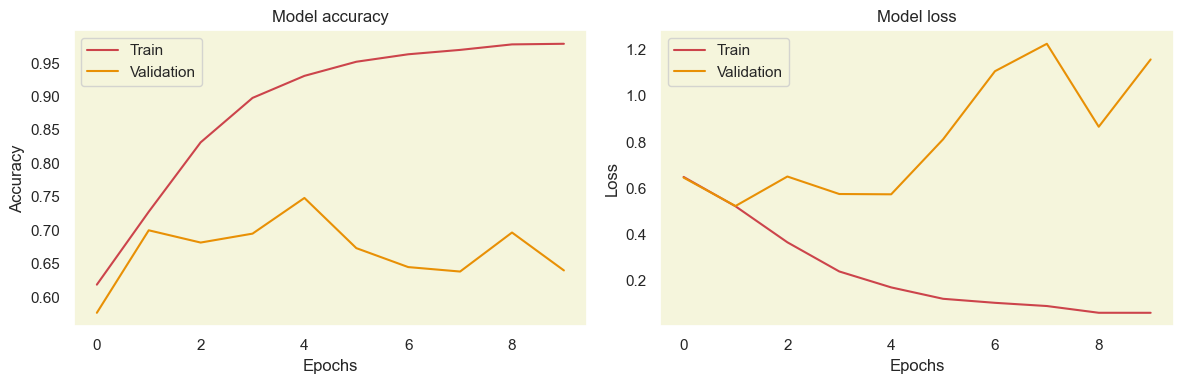

In [131]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [132]:
#This cell saves the trained model to an .h5 file

In [133]:
model.save('fracture_classification_model.h5')

In [134]:
#This cell loads the saved model from the .h5 file.

In [135]:
loaded_model = tf.keras.models.load_model('fracture_classification_model.h5')

In [136]:
#This cell defines a function to load and preprocess a custom image.

In [145]:
def load_preprocessed_image(image_path, img_height=180, img_width=180):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = 'data/bonefracture/train/not fractured/5.JPG'
preprocessed_img = load_preprocessed_image(image_path)

In [147]:
#Make Predictions on Custom Image

In [149]:
predictions = loaded_model.predict(preprocessed_img)
predicted_class = np.argmax(predictions, axis=1)  # Assuming categorical output
class_names = ['fractured', 'not fractured']
# For binary classification, use:
predicted_class = (predictions > 0.5).astype("int32")

# Print the predicted class
print(f"Predicted class: {class_names[predicted_class[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Predicted class: not fractured
